# Introduction to Photometry

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: Demonstrate photometry on a series of bias and flat field corrected images of a Near Earth Asteroid. 

## 0. Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

### 0.1 Directory Set up

In [2]:
datadir = 'PointSourcePhotometry_DF/'
objname  = '2016HO3'

### 0.2 Display images

In [3]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(numb))[0].data

    f = plt.figure(figsize=(10,12))
    #im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:580, 460:600], cmap='hot')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.034, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()

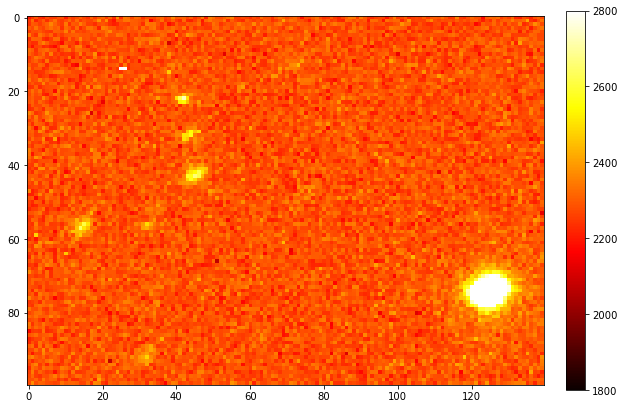

In [4]:
numb = 1 
plotfits(numb)

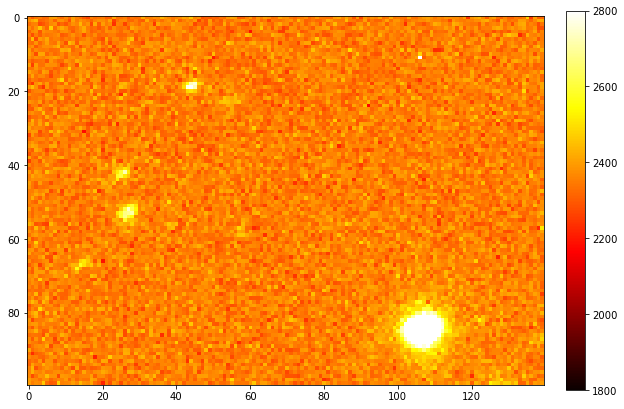

In [5]:
numb = 2
plotfits(numb)

## 1. Photometry set up

Select part of the image for ease of display.

In [6]:
partimg = fits.open(datadir+objname+'_01.fits'.format(numb))[0].data[480:580, 460:600]

Define starting values. Fill in values here:

In [30]:
targcen = np.array([23,43])  ## target center
compcen = np.array([75,125])  ## comparison center

Aperture photometry set up. Play around with adjusting the aperture radii sizes and see the resulting image under 'Tests'

In [31]:
searchr = 6  ## search box size
ap_r    = 2   ## aperture radius

sky_inner = 3
sky_outer = 5

### 1.1 Centroiding: Center of Mass

Calculate Center of Mass (CoM) defined as: $\bar{x} = \frac{\sum A_i x_i}{\sum A_i }$, $\bar{y} = \frac{\sum A_i  y_i}{\sum A_i }$.

In [32]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    
    cent=np.zeros((2),np.float)
    temp=sum(sum(psf)-min(sum(psf)))
    cent[1]=sum((sum(psf-min(sum(psf))))*weights)/temp
    cent[0]=sum((sum(psf.T)-min(sum(psf.T)))*weights)/temp
    return cent

Use centroiding algorithm to find the actual centers of the targe and comparison.

In [33]:
## Cut a box between search limits, centered around targcen
targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]
weights = cent_weight(len(targbox))
tcenoffset = calc_CoM(targbox, weights)
tcenter = targcen + tcenoffset

[-0.8004721  -0.25229707]


Inspect PSF to see whether shift makes sense

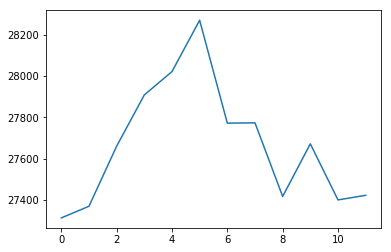

In [34]:
plt.plot(sum(targbox))
plt.show()

In [35]:
compbox = partimg[compcen[0]-searchr:compcen[0]+searchr, compcen[1]-searchr:compcen[1]+searchr]
compw = cent_weight(len(compbox))
ccenoffset = calc_CoM(compbox,compw)
ccenter = compcen + ccenoffset

(100, 140)
69 81 119 131
[-5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5]


In [36]:
print(tcenter)

[ 22.1995279   42.74770293]


In [37]:
compw

array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,
        5.5])

### 1.2 Aperture Photometry

#### Science Aperture

In [38]:
def circle(npix, r1):
    """
    Builds a circle
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            r=np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if r<=r1:
                pup[i,j]=1
    return pup

#### Sky annulus

In [39]:
def annulus(npix, r_inner,r_outer=-1.):
    """
    Builds an annulus
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            r=np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if ((r<=r_outer)&(r>=r_inner)):
                pup[i,j]=1
    return pup

#### Extract values from regions

Create mask

In [40]:
circmask = circle(searchr*2, ap_r)
annmask = annulus(searchr*2, sky_inner, sky_outer)

Define new regions where the target and comparison are centered.

In [41]:
newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]

Place mask on region

In [42]:
targaper = newtarg * circmask
compaper = newcomp * circmask

Place mask on sky annulus slice. 

In [43]:
targann = newtarg * annmask
compann = newcomp * annmask

### 1.3 Tests

a. Display image with target and comparison centers before and after centroiding

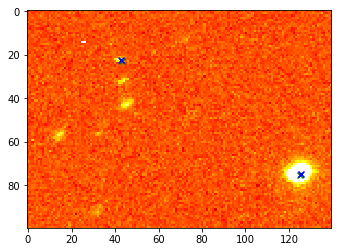

In [44]:
im = plt.imshow(partimg, cmap='hot')
plt.clim(1800, 2800)
plt.scatter(targcen[1], targcen[0], c='g', marker='x')
plt.scatter(compcen[1], compcen[0], c='g', marker='x')
plt.scatter(tcenter[1], tcenter[0], c='b', marker='x')
plt.scatter(ccenter[1], ccenter[0], c='b', marker='x')
plt.show()

b. Disply image with aperture mask and sky annulus

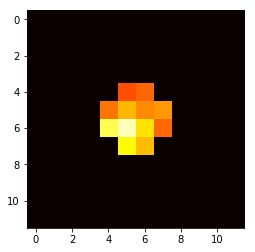

In [45]:
im = plt.imshow(targaper, cmap='hot')
plt.clim(1800, 2800)
plt.show()

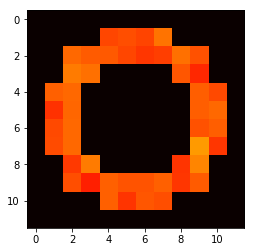

In [46]:
im = plt.imshow(targann, cmap='hot')
plt.clim(1800, 2800)
plt.show()

## 2. Photometry

### 2.1 Calculate SNR

Calculate Signal-to-Noise Ratio. CCD noise = sqrt(signal + background + dark current + read noise). Ignore dark current and read noise here. 

In [47]:
def calcsnr(target, bg):
    signal = target - bg
    noise = np.sqrt(signal + bg)
    snr = signal / noise
    return snr, noise   

Sum all flux inside target and comparison apertures and divide by number of pixels to get average count per pixel.

In [48]:
targc = np.sum(targaper) / np.sum(circmask)
targbg= np.sum(targann) /  np.sum(annmask)
compc = np.sum(compaper) /  np.sum(circmask)
compbg= np.sum(compann) /  np.sum(annmask)

In [49]:
snr, noise = calcsnr(targc, targbg)
print(snr)

3.016576908


In [50]:
snr, noise = calcsnr(compc, compbg)
print(snr)

170.310735282


### 2.2 Optimize photometry aperture

[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


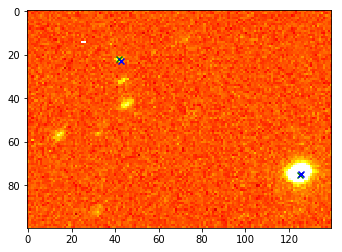

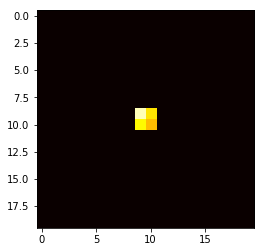

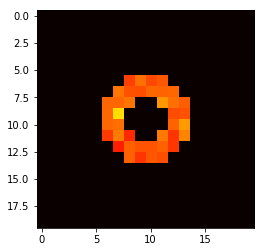

1 4.88723135055
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


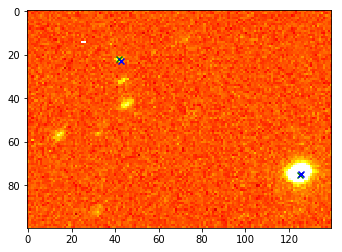

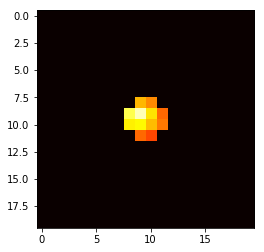

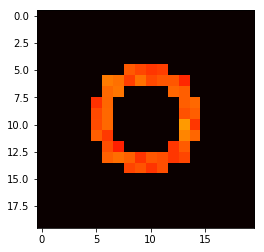

2 3.26291182355
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


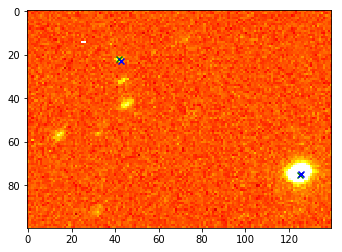

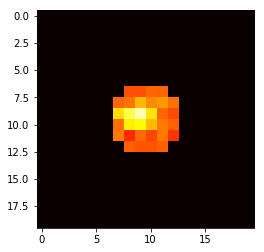

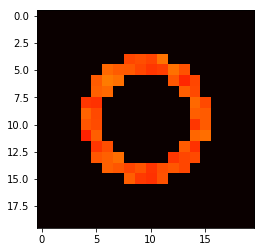

3 1.70494132595
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


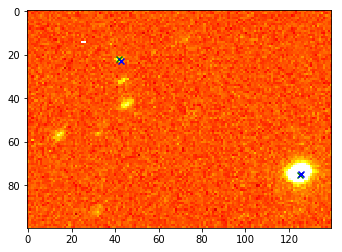

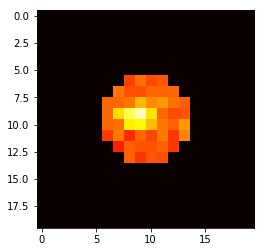

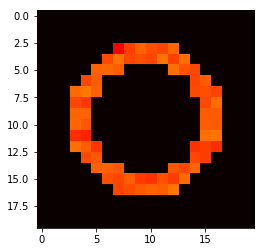

4 1.10495803968
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


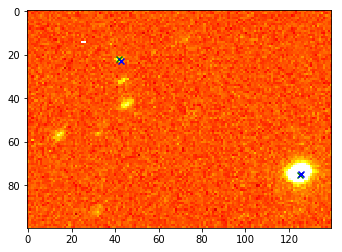

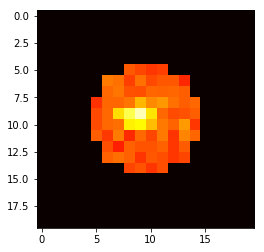

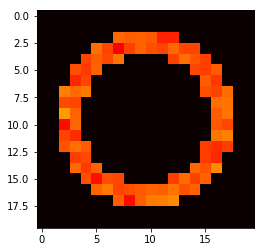

5 0.684186400349
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


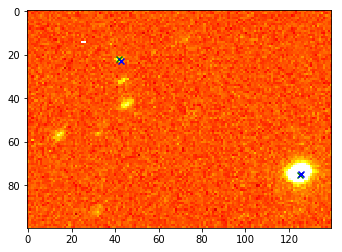

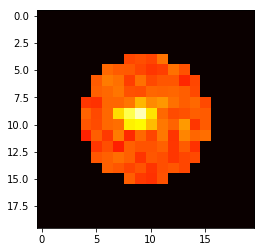

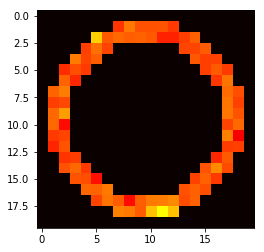

6 0.349926787692
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


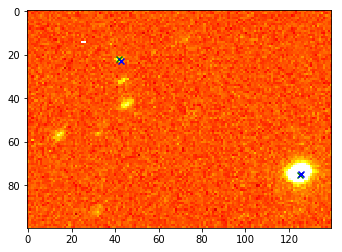

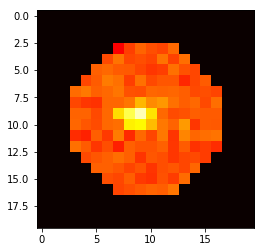

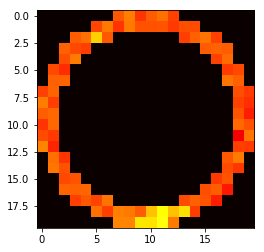

7 -0.00580611870369
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


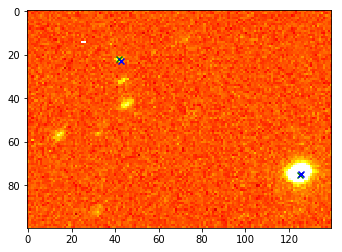

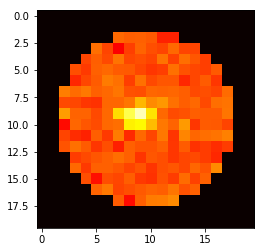

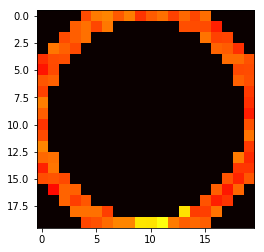

8 0.0439302808306
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


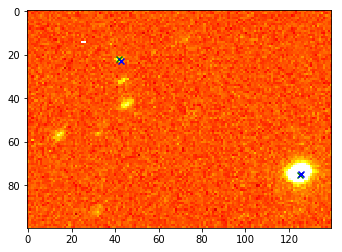

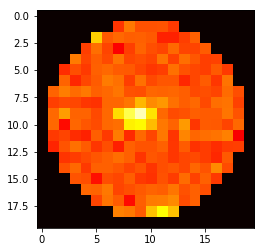

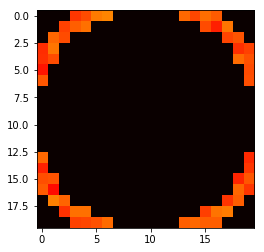

9 0.313244258137
[ 22.9132417   42.52617165] [  74.67870692  125.3244222 ]


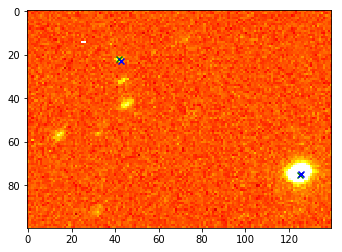

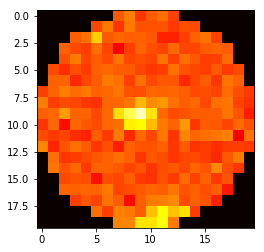

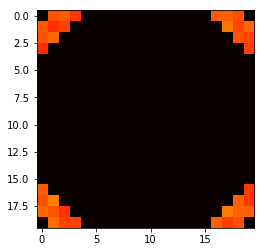

10 0.329396226971
0
1 4.88723135055


In [65]:
apertures=[1,2,3,4,5,6,7,8,9,10]
snrs=np.zeros_like(apertures, dtype=float)
searchr = 10
targcen = np.array([22,42])  ## target center
compcen = np.array([75,125])
for i in range(0,len(apertures)):
    sky_inner=apertures[i]+1
    sky_outer=sky_inner+2
    targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]
    weights = cent_weight(len(targbox))
    tcenoffset = calc_CoM(targbox, weights)
    tcenter = targcen + tcenoffset
    compbox = partimg[compcen[0]-searchr:compcen[0]+searchr, compcen[1]-searchr:compcen[1]+searchr]
    compw = cent_weight(len(compbox))
    ccenoffset = calc_CoM(compbox,compw)
    ccenter = compcen + ccenoffset
    print(tcenter, ccenter)
    im = plt.imshow(partimg, cmap='hot')
    plt.clim(1800, 2800)
    plt.scatter(targcen[1], targcen[0], c='g', marker='x')
    plt.scatter(compcen[1], compcen[0], c='g', marker='x')
    plt.scatter(tcenter[1], tcenter[0], c='b', marker='x')
    plt.scatter(ccenter[1], ccenter[0], c='b', marker='x')
    plt.show()
    circmask = circle(searchr*2, apertures[i])
    annmask = annulus(searchr*2, sky_inner, sky_outer)
    newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
    newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]
    targaper = newtarg * circmask
    compaper = newcomp * circmask
    targann = newtarg * annmask
    compann = newcomp * annmask
    im = plt.imshow(targaper, cmap='hot')
    plt.clim(1800, 2800)
    plt.show()
    im = plt.imshow(targann, cmap='hot')
    plt.clim(1800, 2800)
    plt.show()
    targc = np.sum(targaper) / np.sum(circmask)
    targbg= np.sum(targann) /  np.sum(annmask)
    compc = np.sum(compaper) /  np.sum(circmask)
    compbg= np.sum(compann) /  np.sum(annmask)
    snr, noise = calcsnr(targc, targbg)
    snrs[i]=snr
    print(apertures[i], snr)
best=np.argmax(snrs)
print(best)
print(apertures[best], snrs[best])

In [51]:
print(bestaper)
print(snr)

NameError: name 'bestaper' is not defined

### 2.3 Calculate the target's magnitude and uncertainty


Given the comparison is of known magnitude of 19.4

In [76]:
ap_r=1
searchhr=6
sky_inner=ap_r+1
sky_outer=sky_inner+2
targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]
weights = cent_weight(len(targbox))
tcenoffset = calc_CoM(targbox, weights)
tcenter = targcen + tcenoffset
compbox = partimg[compcen[0]-searchr:compcen[0]+searchr, compcen[1]-searchr:compcen[1]+searchr]
compw = cent_weight(len(compbox))
ccenoffset = calc_CoM(compbox,compw)
ccenter = compcen + ccenoffset
newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]
targc=circle(searchr*2,ap_r)*newtarg
targskyc=annulus(searchr*2, sky_inner, sky_outer)*newtarg
compc=circle(searchr*2,ap_r)*newcomp
compskyc=annulus(searchr*2, sky_inner, sky_outer)*newcomp

ratio=np.sum(compc)/np.sum(targc)
sigmaratio=ratio*np.sqrt((np.sum(targc)/np.sum(targskyc))**2+(np.sum(compc)/np.sum(compskyc))**2)
print(ratio, sigmaratio)
deltamag=-2.5*np.log10(ratio)
sigmamag=2.5*sigmaratio/(ratio*np.log(10))
refmag=19.4
mag=refmag-deltamag
print("Measured Magnitude = {:0.3f}+- {:0.3f}".format(mag, sigmamag))

20.2635011728 12.7438023083
Measured Magnitude = 22.667+- 0.683


# Further Exercises

a. Perform photometry on all 10 images of the asteroid and find its period of rotation.

b. Perform photometry using Gaussian PSF fitting. 